## Question 1
1. Perform logistic regression <br>
    a. Do not include interactions <br>
1. Interpret coefficients <br>
    a. Include hypothesis testing and confidence intervals <br>
1. Comment on pratical vs statistical significance of important factors

## Introduction

xcxcxcxcxcxcxcxcxcxcxccccxcfsdfsfsdfsdfadafafas

In [1]:
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data import
df = pd.read_csv("hmeq.csv") 

## Exploratory Data Analysis

In [3]:
df.shape # Get a quick summary of table structure

(5960, 13)

In [4]:
df.info() # Get a view of data types withing the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
BAD        5960 non-null int64
LOAN       5960 non-null int64
MORTDUE    5442 non-null float64
VALUE      5848 non-null float64
REASON     5708 non-null object
JOB        5681 non-null object
YOJ        5445 non-null float64
DEROG      5252 non-null float64
DELINQ     5380 non-null float64
CLAGE      5652 non-null float64
NINQ       5450 non-null float64
CLNO       5738 non-null float64
DEBTINC    4693 non-null float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


This dataset seems to have some missing values that need to be addressed before EDA. Lets take a look below.

In [5]:
# View the first 5 rows
df.head() 

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


Now lets take a closer look at the missing values by column.'DEBTINC' (Debt to Income ratio) is missing for more than 20% of its values followed by 'DEROG' at 11%. That may be too many values to impute. We may want to impute values within groupings as a alternative. For example, 'DEBTINC' mean or median values may be significantly different for "Sales" vs "Other" job titles. We need to explore deeper to see if there is a story to uncover if we decide to impute.

In [6]:
# sort desc
df_percent = df.isna().sum()/len(df)*100 # Percent of total 'NaN' rows by column
df_percent.sort_values(ascending=False)

DEBTINC    21.258389
DEROG      11.879195
DELINQ      9.731544
MORTDUE     8.691275
YOJ         8.640940
NINQ        8.557047
CLAGE       5.167785
JOB         4.681208
REASON      4.228188
CLNO        3.724832
VALUE       1.879195
LOAN        0.000000
BAD         0.000000
dtype: float64

Almost half of the dataset is lost if we remove all rows with at least 1 NaN value. That isn't necessarily a bad thing, but it is worth noting. Imputing variables may be an option at a later juncture. We will move forward by simply removing rows with missing values for now.

In [7]:
#Create new dataframe with NaN rows removed
df_NoNaN = df.dropna() 

# comparing NEW (df) vs OLD (df2) dataframes 
print("Old data frame length:", len(df), "\nNew data frame length:",  
       len(df_NoNaN), "\nNumber of rows with at least 1 NA value: ", 
       (len(df)-len(df_NoNaN)),"\nPercent of total rows lost to NA values:",
     (len(df)-len(df_NoNaN))/len(df))

Old data frame length: 5960 
New data frame length: 3364 
Number of rows with at least 1 NA value:  2596 
Percent of total rows lost to NA values: 0.4355704697986577


## Exploratory Data Analysis Part 2

Lets split the summary by the binary response variable to get a better overview.

In [8]:
df[df['BAD']==0].drop('BAD', axis=1).describe().style.format("{:.2f}") # Summary stats for Paid loans

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,4771.00,4359.00,4764.00,4321.00,4150.00,4263.00,4541.00,4336.00,4602.00,4290.00
mean,19028.11,74829.25,102595.92,9.15,0.13,0.25,187.00,1.03,21.32,33.25
std,11115.76,43584.99,52748.39,7.68,0.51,0.67,84.47,1.53,9.68,6.95
min,1700.00,2619.00,8000.00,0.00,0.00,0.00,0.49,0.00,0.00,0.72
25%,11700.00,47484.00,67297.75,3.00,0.00,0.00,120.22,0.00,15.00,28.91
50%,16900.00,66839.00,90659.00,7.00,0.00,0.00,180.42,1.00,20.00,34.54
75%,23500.00,93068.00,120615.50,13.00,0.00,0.00,240.16,2.00,26.00,38.74
max,89900.00,371003.00,471827.00,36.00,6.00,5.00,649.75,11.00,56.00,45.57


In [9]:
df[df['BAD']==1].drop('BAD', axis=1).describe().style.format("{:.2f}") # Summary stats for Default loans

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,1189.00,1083.00,1084.00,1124.00,1102.00,1117.00,1111.00,1114.00,1136.00,403.00
mean,16922.12,69460.45,98172.85,8.03,0.71,1.23,150.19,1.78,21.21,39.39
std,11418.46,47588.19,74339.82,7.10,1.47,1.90,84.95,2.25,11.81,17.72
min,1100.00,2063.00,8800.00,0.00,0.00,0.00,0.00,0.00,0.00,0.52
25%,9200.00,39946.50,59368.25,2.00,0.00,0.00,96.03,0.00,13.00,32.38
50%,14900.00,60279.00,82000.00,6.00,0.00,0.00,132.87,1.00,20.00,38.08
75%,21700.00,85864.50,116000.00,12.00,1.00,2.00,193.28,3.00,28.00,43.29
max,77400.00,399550.00,855909.00,41.00,10.00,15.00,1168.23,17.00,71.00,203.31


In [10]:
# Create dataframe for numeric values only
df_numeric = df_NoNaN._get_numeric_data()

In [11]:
df_numeric.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5,1,1700,30548.0,40320.0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
7,1,1800,28502.0,43034.0,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
19,0,2300,102370.0,120953.0,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503
25,1,2400,34863.0,47471.0,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601
26,0,2400,98449.0,117195.0,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827


### Scatterplot Matrices

Is normality important? Do we need to tranform data? None of the variables seem to show multicollinearity except "VALUE" and "MORTDUE". As home values increase so does the TOTAL mortgage due which would makes sense. We may not need both variables, but we will asses that in later modeling efforts.  

/Users/kitopatterson/miniconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 0.98, 'HMEQ Numeric Pairwise Plots')

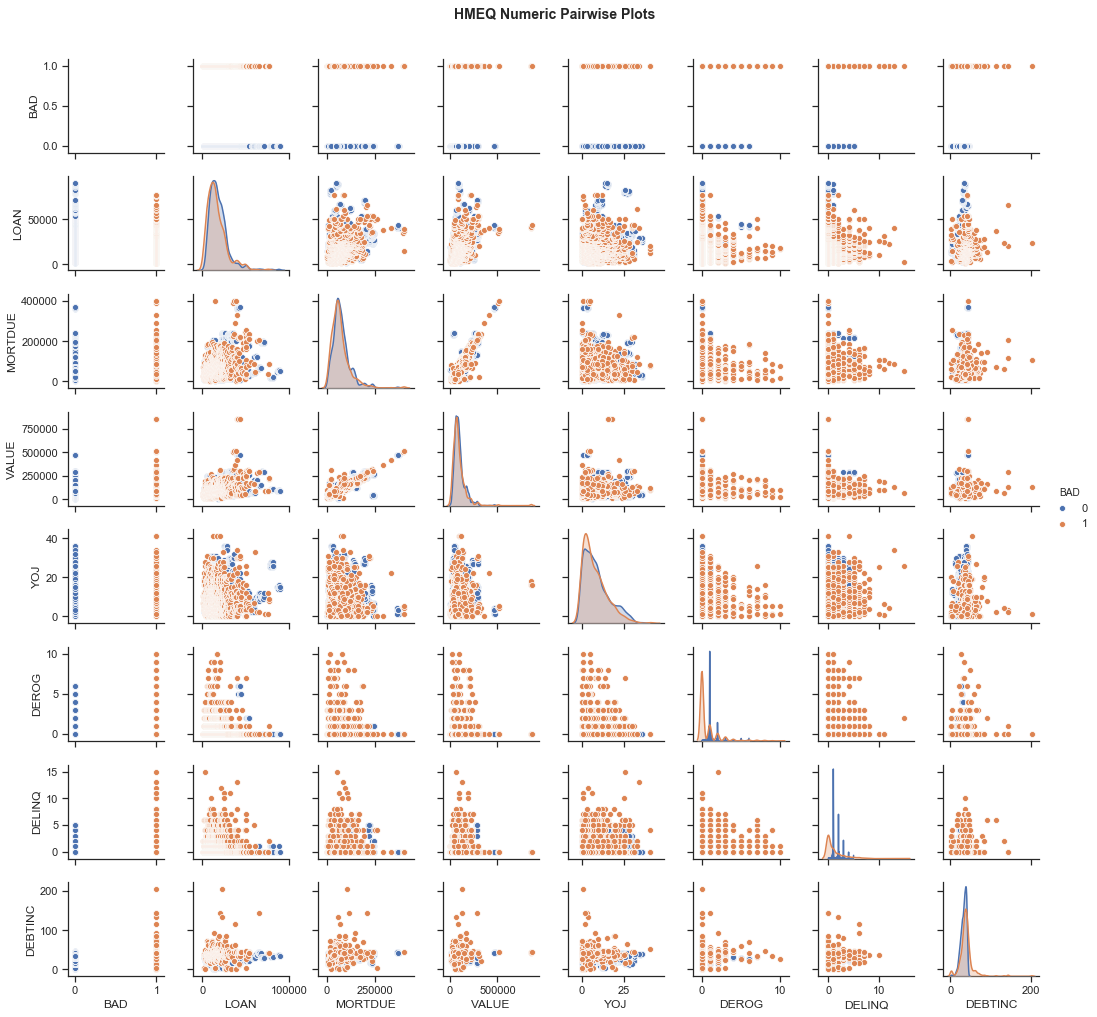

In [12]:
# Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="ticks")

cols_cont = ['BAD','LOAN','MORTDUE','VALUE','YOJ','DEROG','DELINQ','DEBTINC']

pp = sns.pairplot(df[cols_cont], 
                  size=1.8,
                  aspect=1.0,
                  hue="BAD")
fig = pp.fig
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('HMEQ Numeric Pairwise Plots', 
              fontsize=14, fontweight='bold')

### Heatmap

The heatmap shows 'VALUE' and 'MORTDUE' as the only variables at risk of mulitcollinearity.

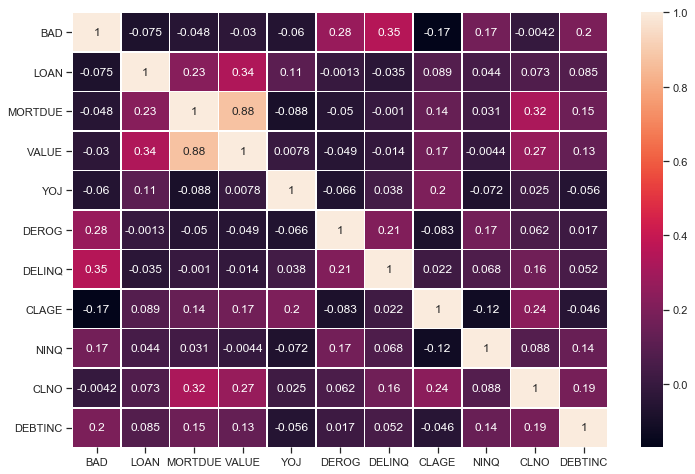

In [13]:
plt.figure(figsize=(12,8))

sns.heatmap(df.corr(), annot=True, linewidth=0.5)

### VIF

Although the scatterplot matrix gives us a good visual of possible multicollinearity, VIF values gives us an additional measure to safe guard against collenearity amongst explanatory variables. As suspected, 'VALUE' and 'MORTDUE' are borderline, but they fall under the accetable threshold (VIF >5). In a attempt to reduce the amount of variables and complexities in our model, we will remove one of the two variables in support of subsequent modeling efforts.

In [14]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Break into left and right hand side; y and X
y, X = dmatrices(formula_like = "BAD ~ LOAN + MORTDUE + VALUE + YOJ + DEROG + DELINQ + CLAGE + NINQ + CLNO + DEBTINC", 
                 data = df_numeric, NA_action = "drop", return_type = "dataframe")

# For each Xi, calculate VIF
vif = pd.DataFrame()
vif['factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns

# Inspect VIF Factors
vif

,factor,features
0,29.163207,Intercept
1,1.221217,LOAN
2,4.614185,MORTDUE
3,4.666531,VALUE
4,1.099876,YOJ
5,1.068688,DEROG
6,1.050184,DELINQ
7,1.162191,CLAGE
8,1.076006,NINQ
9,1.219552,CLNO


We will remove the 'VALUE' variable given it is has a VIF closest to 5. This will allow us to reduce model complexity as much as possible before our model/feature selection efforts. 

In [15]:
# Drop NaN values from both dataframes
df.drop(['VALUE'], axis=1, inplace=True)
df_NoNaN.drop(['VALUE'], axis=1, inplace=True)

In [16]:
df.head()

,BAD,LOAN,MORTDUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [17]:
df_NoNaN.head()

,BAD,LOAN,MORTDUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
5,1,1700,30548.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
7,1,1800,28502.0,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
19,0,2300,102370.0,HomeImp,Office,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503
25,1,2400,34863.0,HomeImp,Mgr,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601
26,0,2400,98449.0,HomeImp,Office,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827


### Identifying Outliers

Forward, Backward and stepwise modeling selection techniques require that you have some semblenace of variable order and importance. Given this isn't our domain expertise, and to reduce the amount of steps, we've opted for a Lasso regression model. 

In [18]:
#from sklearn.linear_model import Lasso

#reg = linear_model.Lasso(alpha=0.1)
#reg.fit()
#lasso = Lasso()



### Analyzing Data

In [19]:
# Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

The response variable is severly unbalanced. We may need to address this behavior when modeling. 

Text(0.5, 1.0, 'Default Counts Yes/No')

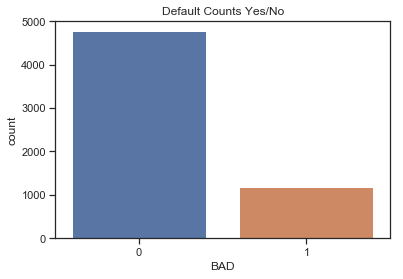

In [20]:
sns.countplot(x="BAD",data=df).set_title('Default Counts Yes/No')

Most borrowers are using their property equity to consolidate debt 

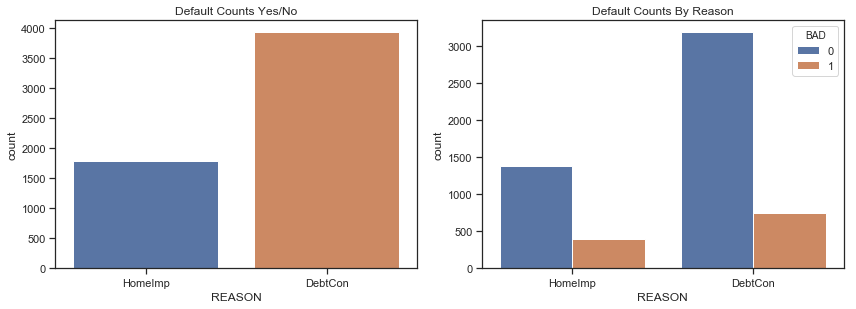

In [21]:
# How to get Percent values by attribute shown on graphs?
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.countplot(x="REASON",data=df).set_title('Default Counts Yes/No')

plt.subplot(222)
sns.countplot(x="REASON", hue="BAD", data=df).set_title('Default Counts By Reason')

#plt.subplot(223)
#sns.countplot(x="JOB", hue="BAD", data=df).set_title('Default Counts By Job Type')

plt.tight_layout()

Borrowers who default tend to have slighty less years on the job than borrowers who don't default. They are likely less established with lower salaries that may signal more defaults. There also seems to be some seperation between both response populations and "CLAGE" (Age of oldest tradeline in # of months). This could indicate that less credit history can potentially lead to higher defaults. It is important to note the mean for defaults are skewed by a few outliers. We may need to investigate those observations further.

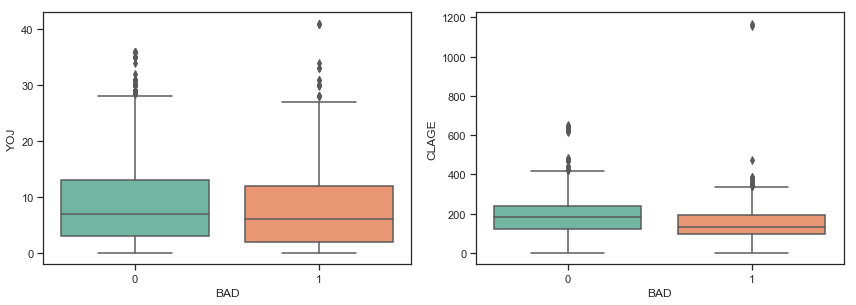

In [22]:
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.boxplot(x="BAD", y="YOJ", data=df, palette="Set2")

plt.subplot(222)
sns.boxplot(x="BAD", y="CLAGE", data=df, palette="Set2")

plt.tight_layout()

There seems to be a good deal of interaction between the factor levels. 
This may suggest subsequent models may perform better with interaction terms included.

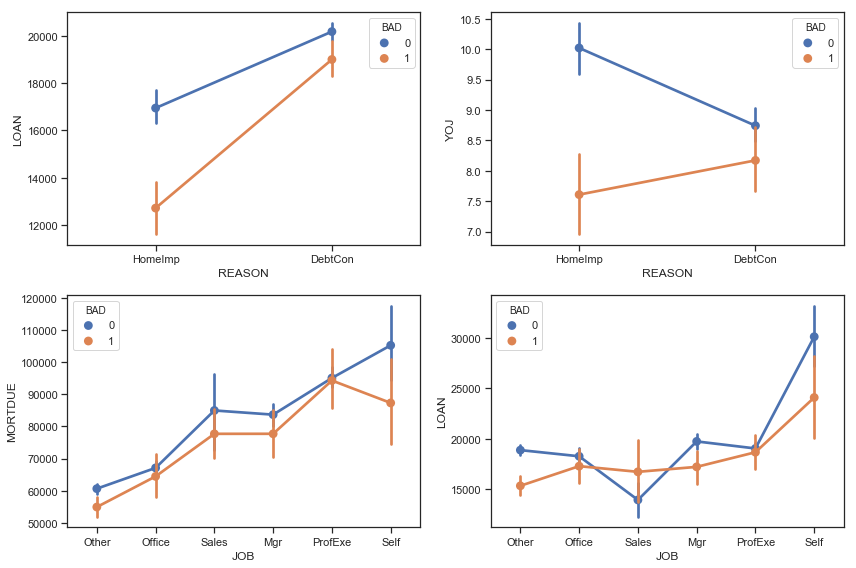

In [23]:
plt.figure(figsize=(12,8))

plt.subplot(221)
sns.pointplot(x="REASON", y="LOAN", hue="BAD", data=df)

plt.subplot(222)
sns.pointplot(x="REASON", y="YOJ", hue="BAD", data=df)

plt.subplot(223)
sns.pointplot(x="JOB", y="MORTDUE", hue="BAD", data=df)

plt.subplot(224)
sns.pointplot(x="JOB", y="LOAN", hue="BAD", data=df)

#plt.subplot(225)
#sns.pointplot(x="JOB", y="VALUE", hue="BAD", data=df)

plt.tight_layout()

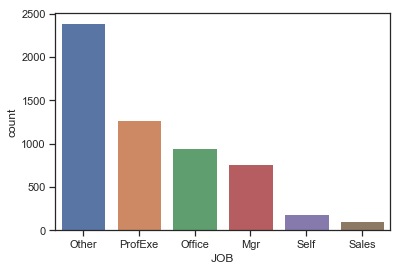

In [24]:
#sns.set()
order=["Other","ProfExe","Office","Mgr","Self","Sales"]

sns.countplot(x="JOB", order=order, data=df)

### Initial Modeling

In [25]:
import scipy as sci
import sklearn as sl

First, we will fit a simple model with all of the explanatory variables to get a idea of predictive baseline performance.

In [26]:
# Create dummy variables and drop the baseline dummy
df_dummies = pd.get_dummies(df_NoNaN,columns=['REASON', 'JOB'], drop_first=True)

In [27]:
# Check to ensure dummy variables were created.
df_dummies.head()

,BAD,LOAN,MORTDUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
5,1,1700,30548.0,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614,1,0,1,0,0,0
7,1,1800,28502.0,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894,1,0,1,0,0,0
19,0,2300,102370.0,2.0,0.0,0.0,90.992533,0.0,13.0,31.588503,1,1,0,0,0,0
25,1,2400,34863.0,12.0,0.0,0.0,70.491080,1.0,21.0,38.263601,1,0,0,0,0,0
26,0,2400,98449.0,4.0,0.0,0.0,93.811775,0.0,13.0,29.681827,1,1,0,0,0,0


In [28]:
# Scale continuous variables except response and dummy variables. <br> 
# Interpretation of coefficients may be difficult as a result

#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# scaler = preprocessing.StandardScaler()
scaler = MinMaxScaler()

# Standardize everything EXCEPT the indicatior variables
df_dummies[['LOAN','MORTDUE','YOJ',
            'DEROG','DELINQ',
            'CLAGE','NINQ',
            'CLNO','DEBTINC']] = scaler.fit_transform(df_dummies[['LOAN','MORTDUE','YOJ',
                                                                  'DEROG','DELINQ',
                                                                  'CLAGE','NINQ',
                                                                  'CLNO','DEBTINC']])

/Users/kitopatterson/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [29]:
# Ensure varaibles have been scalled between 0 and 1
df_dummies.head()

,BAD,LOAN,MORTDUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
5,1,0.000000,0.064595,0.219512,0.0,0.0,0.086474,0.076923,0.125000,0.253054,1,0,1,0,0,0
7,1,0.001134,0.059406,0.268293,0.0,0.0,0.075598,0.000000,0.125000,0.251458,1,0,1,0,0,0
19,0,0.006803,0.246729,0.048780,0.0,0.0,0.077505,0.000000,0.203125,0.214511,1,1,0,0,0,0
25,1,0.007937,0.075537,0.292683,0.0,0.0,0.059948,0.076923,0.328125,0.261076,1,0,0,0,0,0
26,0,0.007937,0.236785,0.097561,0.0,0.0,0.079919,0.000000,0.203125,0.201211,1,1,0,0,0,0


In [30]:
# Create target and feature variables
features = ['LOAN','MORTDUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC',
           'REASON_HomeImp', 'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self']

X = df_dummies[features] # Features
y = df_dummies['BAD'] # Target

In [31]:
from sklearn.model_selection import train_test_split

# 75/25 training/test split. random_state equivalent to set.seed in R
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

### LASSO Regression (Scikit Learn Library)

In [32]:
from sklearn.linear_model import LogisticRegression

#Optimizing logistic function with L1 penalty (LASSO)
logreg = LogisticRegression(penalty='l1', solver='liblinear')
lrf = logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

It looks like the Lasso Regression worked as expected. 2 of the variable coefficients were shrunk toward zero, essentially removing them from the model.

In [33]:
# Still need to figure out how to print summary table. Sklearn doesn't allow.
lrf.coef_

array([[-0.93095113,  0.        , -0.1935585 ,  6.26522199,  6.33414015,
        -5.93777339,  1.02862774, -0.34175919, 10.91766626, -0.05152882,
        -0.60534424,  0.        , -0.17423549,  0.93146919,  0.39305138]])

### Initial Logistic Regression Model Evaluation

In [34]:
# Define confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test,y_pred)

In [35]:
confusion_matrix(y_test,y_pred)

array([[615,   3],
       [ 43,  12]])

In [36]:
# Define plot. Given by sklearn website
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('binary')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

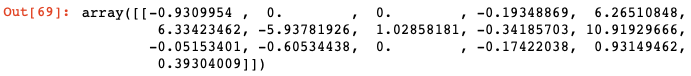

In [37]:
from sklearn.metrics import accuracy_score

score = accuracy_score(y_test,y_pred) 

round(score*100,2)

93.16

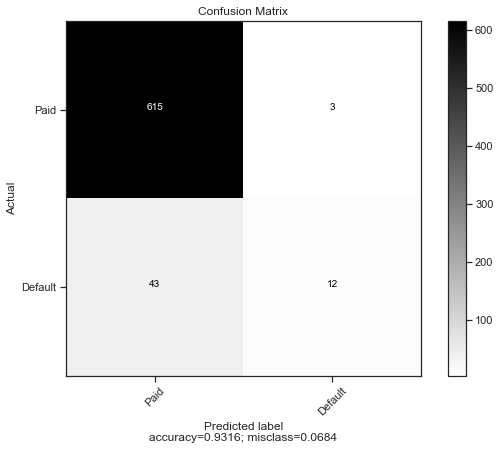

In [38]:
plot_confusion_matrix(cm           = cnf_matrix, 
                      normalize    = False,
                      target_names = ['Paid', 'Default'],
                      title        = "Confusion Matrix")


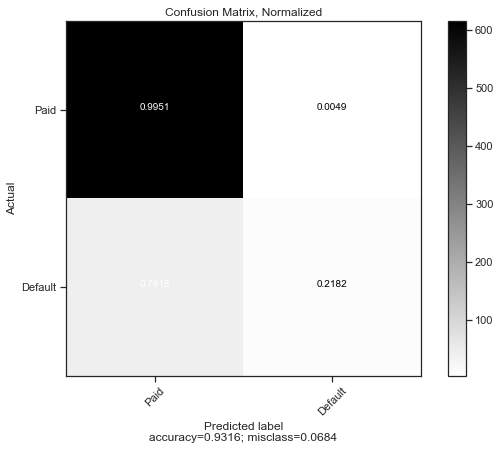

In [39]:
plot_confusion_matrix(cm           = cnf_matrix, 
                      normalize    = True,
                      target_names = ['Paid', 'Default'],
                      title        = "Confusion Matrix, Normalized")

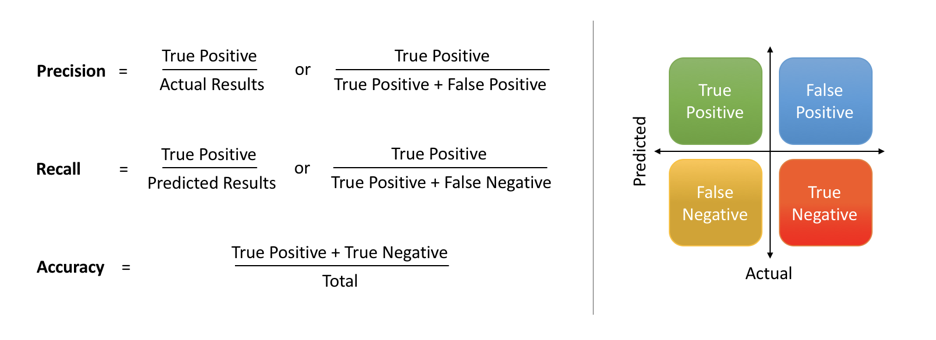

In [40]:
# Precision = 
# Recall = how many of the observed cases were correctly predicted?
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.93      1.00      0.96       618
           1       0.80      0.22      0.34        55

   micro avg       0.93      0.93      0.93       673
   macro avg       0.87      0.61      0.65       673
weighted avg       0.92      0.93      0.91       673



### LASSO Regression (Statsmodels Library)

In [51]:
# Logistic Regression with LASSO 
import statsmodels.api as sm 
from scipy import stats

logit_model=sm.Logit(y_train,X_train)


N = len(y_train)
K = X_train.shape[1]
alpha = 0.01 * N * np.ones(K)

result=logit_model.fit_regularized(method='l1',alpha=alpha)
print(result.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.28429229603871753
            Iterations: 173
            Function evaluations: 173
            Gradient evaluations: 173
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2691
Model:                          Logit   Df Residuals:                     2678
Method:                           MLE   Df Model:                           12
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:                  0.1461
Time:                        16:28:34   Log-Likelihood:                -700.72
converged:                       True   LL-Null:                       -820.61
                                        LLR p-value:                 1.835e-44
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

In [43]:
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.253869
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2691
Model:                          Logit   Df Residuals:                     2676
Method:                           MLE   Df Model:                           14
Date:                Mon, 15 Apr 2019   Pseudo R-squ.:                  0.1675
Time:                        16:16:11   Log-Likelihood:                -683.16
converged:                       True   LL-Null:                       -820.61
                                        LLR p-value:                 1.978e-50
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
LOAN              -2.7632      0.786     -3.514      0.000      -4.304      -1.222
MORTDUE          

In [54]:
print(lrf.summary())

AttributeError: 'LogisticRegression' object has no attribute 'summary'

In [ ]:
df['PROP_EQUITY'] = df['VALUE']-df.['MORTDUE'] # Created feature to get a sense of equity value for home